In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sp500 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/S&P500Index.xlsx')

In [5]:
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

In [6]:
start_date = pd.to_datetime('1980-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
sp500_filtered = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

In [7]:
sp500_filtered['Pct Change'] = sp500_filtered['PX_LAST'].pct_change() * 100

In [8]:
sp500_filtered

,Dates,PX_LAST,Pct Change
0,1980-05-19,107.67,NaN
1,1980-05-20,107.62,-0.046438
2,1980-05-21,107.72,0.092920
3,1980-05-22,109.01,1.197549
4,1980-05-23,110.62,1.476929
...,...,...,...
10858,2023-06-12,4338.93,0.932108
10859,2023-06-13,4369.01,0.693258
10860,2023-06-14,4372.59,0.081941
10861,2023-06-15,4425.84,1.217814


# Conditional Parametric Student t VaR

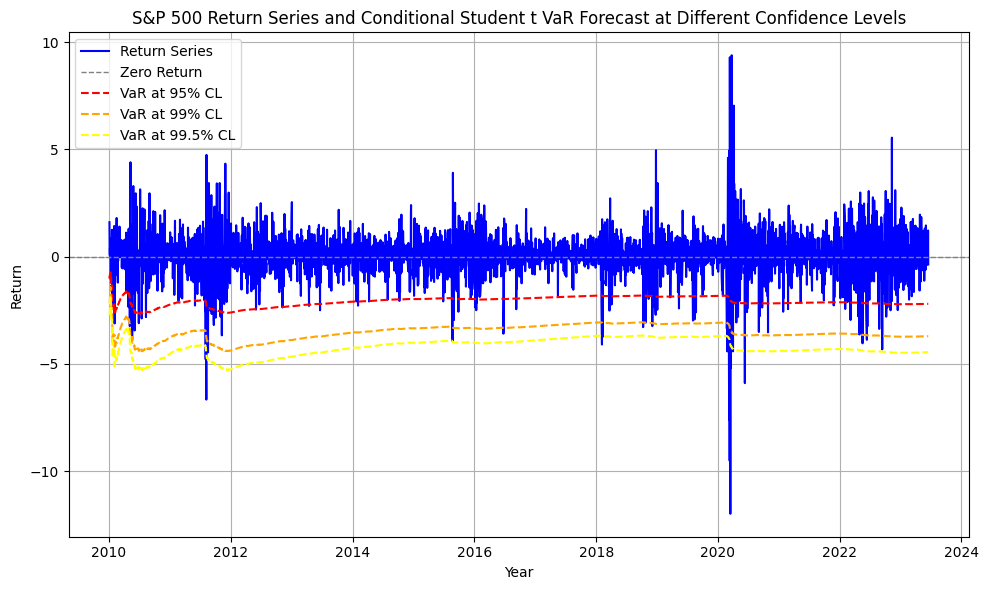

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Initialize lists to store VaR at different confidence levels
VaR_95 = []
VaR_99 = []
VaR_995 = []

# Calculate VaR at each date using the historical data up to that date
for i in range(len(returns)):
    historical_returns = returns[:i+1]
    VaR_95.append(t.ppf(0.05, df=5, loc=historical_returns.mean(), scale=historical_returns.std()))
    VaR_99.append(t.ppf(0.01, df=5, loc=historical_returns.mean(), scale=historical_returns.std()))
    VaR_995.append(t.ppf(0.005, df=5, loc=historical_returns.mean(), scale=historical_returns.std()))

# Plot the return series and the VaR forecast curves
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Zero Return')
plt.plot(filtered_data['Dates'], VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.plot(filtered_data['Dates'], VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.plot(filtered_data['Dates'], VaR_995, linestyle="--", color="yellow", label='VaR at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Conditional Student t VaR Forecast at Different Confidence Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import t
import json

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate VaR at different confidence levels using the t-distribution percent-point function (PPF) with 5 degrees of freedom
VaR = {cl: t.ppf(1 - cl, df=5, loc=mean_return, scale=std_return) for cl in confidence_levels}

# Calculate the probability of violation at different confidence levels
probability_of_violation = {cl: 1 - cl for cl in confidence_levels}

# Calculate the expected number of violations for Another Model at different confidence levels
expected_violations_another_model = {cl: probability_of_violation[cl] * sample_size for cl in confidence_levels}

# Store the expected violations for Another Model in a dictionary
expected_violations_another_model_dict = expected_violations_another_model

# Save the expected violations for Another Model to a JSON file
expected_violations_file_another_model = 'expected_violations_another_model.json'
with open(expected_violations_file_another_model, 'w') as file:
    json.dump(expected_violations_another_model, file)

# Print the results
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations for Another Model: {expected_violations_another_model[cl]:.2f}")
    print("-" * 40)

print(f"Expected violations for Another Model saved to {expected_violations_file_another_model}")


Confidence Level: 0.995
Expected Violations for Another Model: 16.46
----------------------------------------
Confidence Level: 0.99
Expected Violations for Another Model: 32.92
----------------------------------------
Confidence Level: 0.95
Expected Violations for Another Model: 164.60
----------------------------------------
Expected violations for Another Model saved to expected_violations_another_model.json


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import t

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Initialize a dictionary to store the expected violations for Lopez I
exp_vio_lopez_I = {}

# Calculate Lopez I at each confidence level
lopez_I = {}
for cl in confidence_levels:
    # Calculate VaR at the specific confidence level using the Student's t-distribution with 5 degrees of freedom
    VaR_cl = t.ppf(1 - cl, df=5, loc=returns.mean(), scale=returns.std())

    # Calculate the actual number of violations
    actual_violations = np.sum(returns < VaR_cl)

    # Calculate the expected violations for Lopez I
    expected_violations = (1 - cl) * sample_size

    # Store the expected violations in the dictionary
    exp_vio_lopez_I[cl] = expected_violations

    # Calculate Lopez I
    lopez_I[cl] = (actual_violations - expected_violations) / np.sqrt(expected_violations)

# Print the results
print("Lopez I Backtest Results with Conditional Parametric Student t VaR (Degree of Freedom = 5):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations for Lopez I: {exp_vio_lopez_I[cl]:.2f}")
    print(f"Actual Violations: {actual_violations}")
    print(f"Lopez I: {lopez_I[cl]:.4f}")
    print("-" * 40)

# You can now access exp_vio_lopez_I for further use if needed


Lopez I Backtest Results with Conditional Parametric Student t VaR (Degree of Freedom = 5):
Confidence Level: 0.995
Expected Violations for Lopez I: 16.46
Actual Violations: 99
Lopez I: -1.8388
----------------------------------------
Confidence Level: 0.99
Expected Violations for Lopez I: 32.92
Actual Violations: 99
Lopez I: -2.2518
----------------------------------------
Confidence Level: 0.95
Expected Violations for Lopez I: 164.60
Actual Violations: 99
Lopez I: -5.1132
----------------------------------------


In [12]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 10.9 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import t, chi2_contingency
import arch
import json

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=1000)

# Sample size
sample_size = len(returns)

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Access the expected violations for Kupiec Backtest from the first code snippet
expected_violations = exp_vio_lopez_I  # Assuming you have the expected violations in exp_vio_lopez_I

# Define a dictionary to store the actual violations
actual_violations_dict = {}

# Define AR(1)-GARCH(1,1) model
def ar1_garch11_volatility(data):
    model = arch.arch_model(data, vol='Garch', p=1, q=1, dist='t')
    results = model.fit(disp='off')
    if results is not None and results.conditional_volatility is not None:
        return results.conditional_volatility[-1]
    else:
        raise ValueError("AR(1)-GARCH(1,1) model failed to produce valid results.")

# Calculate the actual number of violations at different confidence levels using Conditional Student t VaR
actual_violations = {cl: len(returns[returns < -ar1_garch11_volatility(returns) * t.ppf(1 - cl, df=5)]) for cl in confidence_levels}

# Store the actual violations in the dictionary
actual_violations_dict = actual_violations

# Define a function to perform Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())
    n_violations_nonnegative = max(n_violations, 0)  # Ensure nonnegative values for contingency table
    n_expected_violations_nonnegative = max(n_expected_violations, 0)  # Ensure nonnegative values for contingency table
    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    # Ensure that the observed values are nonnegative for the contingency table
    observed = np.array([[np.maximum(n_violations_nonnegative, 0), np.maximum(n_expected_violations_nonnegative, 0)], [np.maximum(sample_size - n_violations_nonnegative, 0), np.maximum(sample_size - n_expected_violations_nonnegative, 0)]])
    p_value = 1 - chi2_contingency(observed)[1]
    return chi2_statistic, p_value

# Perform Kupiec Backtest
chi2_statistic, p_value = kupiec_backtest(actual_violations, expected_violations)

# Unconditional Coverage of Kupiec (1995)
unconditional_coverage = 1 - p_value

# Independence Test of Christofferson (1998)
independence_test = p_value < 0.05

# Save expected and actual violations to a JSON file named 'violate_data.json'
violations_data = {
    "Expected Violations": expected_violations,
    "Actual Violations": actual_violations_dict
}

with open('violate_data.json', 'w') as json_file:
    json.dump(violations_data, json_file, indent=4)

# Print Backtest Results
print("Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print("-" * 40)

print("Kupiec Backtest:")
print(f"Chi2 Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarn

Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 983
----------------------------------------
Kupiec Backtest:
Chi2 Statistic: nan
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null


<ipython-input-13-850e4c7c9b41>:43: RuntimeWarning: invalid value encountered in log
  chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))


In [14]:
import json
import numpy as np
from scipy.stats import chi2_contingency

# Sample size
sample_size = 3292

# Define the significance level (alpha)
alpha = 0.05

# Load the stored violations data from the JSON file
violations_data_file = 'violate_data.json'  # Change the filename to 'violate_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Define a function to perform Kupiec Backtest for conditional coverage
def kupiec_conditional_backtest(actual, expected):
    n_violations = actual
    n_expected_violations = expected
    chi2_statistic = 2 * (n_violations * np.log(n_expected_violations / n_violations) + (sample_size - n_violations) * np.log((sample_size - n_expected_violations) / (sample_size - n_violations)))
    p_value = 1 - chi2_contingency([[n_violations, n_expected_violations], [sample_size - n_violations, sample_size - n_expected_violations]])[1]
    return chi2_statistic, p_value

# Iterate through all keys in the "Expected Violations" dictionary
for cl_key in violations_data["Expected Violations"]:
    try:
        cl = float(cl_key)  # Convert the confidence level key to a float
        expected = violations_data["Expected Violations"][cl_key]
        actual = violations_data["Actual Violations"][cl_key]

        chi2_statistic, p_value = kupiec_conditional_backtest(actual, expected)
        unconditional_coverage = 1 - p_value

        # Determine whether to reject or fail to reject the null hypothesis
        independence_test = p_value < alpha

        # Print the results
        print(f"Kupiec Conditional Coverage Backtest Results for Confidence Level {cl}:")
        print(f"Confidence Level: {cl}")
        print(f"Expected Violations: {expected}")
        print(f"Actual Violations: {actual}")
        print(f"Chi-squared Value: {chi2_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
        print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")
        print("-" * 40)

    except KeyError:
        print(f"Data not found for Confidence Level {cl_key}")


Kupiec Conditional Coverage Backtest Results for Confidence Level 0.995:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 1000
Chi-squared Value: -6576.8906
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null
----------------------------------------
Kupiec Conditional Coverage Backtest Results for Confidence Level 0.99:
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 1000
Chi-squared Value: -5213.6894
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null
----------------------------------------
Kupiec Conditional Coverage Backtest Results for Confidence Level 0.95:
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 983
Chi-squared Value: -2112.3773
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null
----------------------------------------


In [15]:
import json
import numpy as np
from scipy.stats import norm, chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the expected and actual violations data from the JSON file
violations_data_file = 'violate_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Extract expected and actual violations from the loaded data
expected_violations = {cl: Decimal(str(violations_data["Expected Violations"][str(cl)])) for cl in confidence_levels}
actual_violations = {cl: int(violations_data["Actual Violations"][str(cl)]) for cl in confidence_levels}

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Convert the mean and standard deviation to float (numerical data type)
mean_return = float(mean_return)
std_return = float(std_return)

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - float(cl), mean_return, std_return) for cl in confidence_levels}

# Define a function to perform Independence Test of Christofferson (1998) Backtest
def christofferson_backtest(actual_violations, expected_violations):
    observed = np.array([actual_violations[cl] for cl in confidence_levels])
    expected = np.array([expected_violations[cl] for cl in confidence_levels])
    chi2_statistic, p_value, _, _ = chi2_contingency([observed, expected])
    return chi2_statistic, p_value

# Perform Independence Test of Christofferson Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    chi2_statistic, p_value = christofferson_backtest(actual_violations, expected_violations)
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results
print("Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 1000
Likelihood Ratio Statistic: 169.7652
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 1000
Likelihood Ratio Statistic: 169.7652
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 983
Likelihood Ratio Statistic: 169.7652
P-value: 0.0000
Decision: Reject Null
----------------------------------------


In [16]:
import json
import pandas as pd
import numpy as np
from scipy.stats import norm, binom
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the expected and actual violations data from the JSON file
violations_data_file = 'violate_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Extract expected and actual violations from the loaded data
expected_violations = {cl: Decimal(str(violations_data["Expected Violations"][str(cl)])) for cl in confidence_levels}
actual_violations = {cl: int(violations_data["Actual Violations"][str(cl)]) for cl in confidence_levels}

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Convert the mean and standard deviation to float (numerical data type)
mean_return = float(mean_return)
std_return = float(std_return)

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - float(cl), mean_return, std_return) for cl in confidence_levels}

# Define a function to calculate the Kupiec Backtest p-value
def kupiec_backtest_p_value(actual_violations, expected_violations, sample_size):
    total_violations = sum(actual_violations.values())
    p = total_violations / sample_size
    n = sample_size
    k = sum(expected_violations.values())

    # Calculate the probability of observing at least the total number of violations
    p_value = 1 - binom.cdf(total_violations - 1, n, p)

    return p_value

# Perform Kupiec Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    p_value_kupiec = kupiec_backtest_p_value(actual_violations, expected_violations, sample_size)

    decision_kupiec = 'Reject Null' if p_value_kupiec < 0.05 else 'Fail to Reject Null'

    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results
print("Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 1000
P-value (Kupiec): 0.5151
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 1000
P-value (Kupiec): 0.5151
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 983
P-value (Kupiec): 0.5151
Decision (Kupiec): Fail to Reject Null
----------------------------------------


# Unconditional Parametric Student t VaR

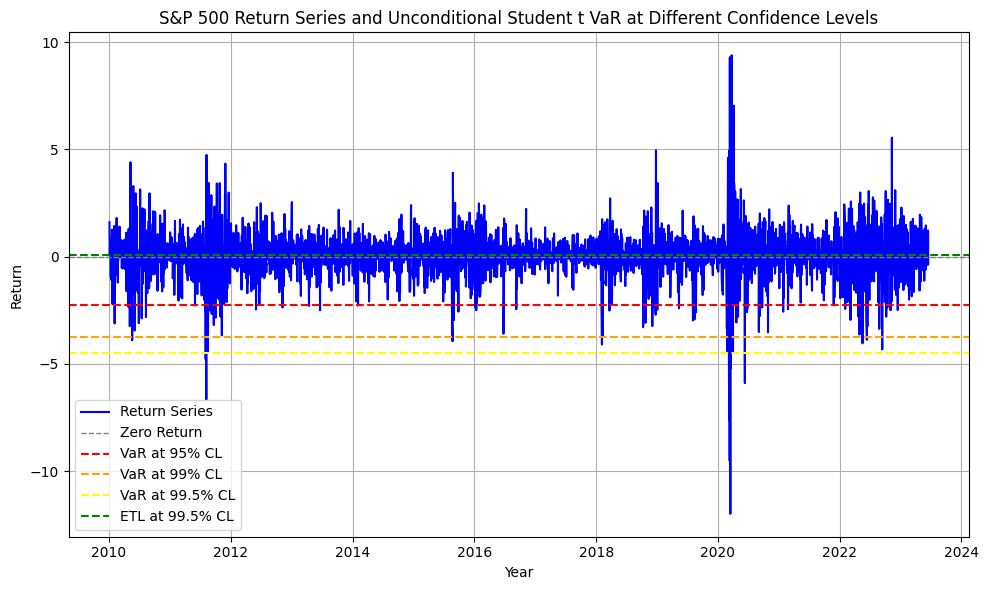

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Calculate the VaR at 95%, 99%, and 99.5% confidence levels using Student t distribution
VaR_95 = t.ppf(0.05, df=5) * returns.std()
VaR_99 = t.ppf(0.01, df=5) * returns.std()
VaR_995 = t.ppf(0.005, df=5) * returns.std()

# Calculate the Expected Tail Loss (ETL) at 99.5% confidence level using Student t distribution
ETL_995 = t.expect(lambda x: x, args=(5,), loc=returns.mean(), scale=returns.std(), lb=VaR_995)

# Plot the return series and the VaR curves
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Zero Return')
plt.axhline(VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.axhline(VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.axhline(VaR_995, linestyle="--", color="yellow", label='VaR at 99.5% CL')
plt.axhline(ETL_995, linestyle="--", color="green", label='ETL at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Unconditional Student t VaR at Different Confidence Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import json

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - cl, mean_return, std_return) for cl in confidence_levels}

# Calculate the probability of violation at different confidence levels
probability_of_violation = {cl: 1 - cl for cl in confidence_levels}

# Calculate the expected number of violations for Lopez I at different confidence levels
expected_violations_lopez_I = {cl: probability_of_violation[cl] * sample_size for cl in confidence_levels}

# Save the expected violations for Lopez I to a JSON file
expected_violations_file = 'expected_violations_lopez_I.json'
with open(expected_violations_file, 'w') as file:
    json.dump(expected_violations_lopez_I, file)

# Print the results
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations for Lopez I: {expected_violations_lopez_I[cl]:.2f}")
    print("-" * 40)

print(f"Expected violations for Lopez I saved to {expected_violations_file}")


Confidence Level: 0.995
Expected Violations for Lopez I: 16.46
----------------------------------------
Confidence Level: 0.99
Expected Violations for Lopez I: 32.92
----------------------------------------
Confidence Level: 0.95
Expected Violations for Lopez I: 164.60
----------------------------------------
Expected violations for Lopez I saved to expected_violations_lopez_I.json


In [19]:
import pandas as pd
import numpy as np
from scipy.stats import t
import json

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Load the expected violations for Lopez I from the JSON file
expected_violations_lopez_I_file = 'expected_violations_lopez_I.json'
with open(expected_violations_lopez_I_file, 'r') as file:
    expected_violations_lopez_I = json.load(file)

# Convert the keys in expected_violations_lopez_I to floats
expected_violations_lopez_I = {float(key): value for key, value in expected_violations_lopez_I.items()}

# Calculate the actual number of violations at different confidence levels
actual_violations = {}
for cl in confidence_levels:
    # Calculate VaR at the specific confidence level using the Student's t-distribution
    VaR_cl = t.ppf(1 - cl, df=5, loc=returns.mean(), scale=returns.std())
    # Count the number of violations
    actual_violations[cl] = int(np.sum(returns < VaR_cl))  # Convert to int

# Use the loaded Lopez I values to calculate the expected violations
expected_violations = {cl: expected_violations_lopez_I[cl] for cl in confidence_levels}

# Calculate Lopez I at each confidence level
lopez_I = {}
for cl in confidence_levels:
    lopez_I[cl] = float((actual_violations[cl] - expected_violations[cl]) / np.sqrt(expected_violations[cl]))  # Convert to float

# Create a dictionary to store the results
results = {
    "Confidence Levels": confidence_levels,
    "Expected Violations": [float(expected_violations[cl]) for cl in confidence_levels],  # Convert to float
    "Actual Violations": [int(actual_violations[cl]) for cl in confidence_levels],  # Convert to int
    "Lopez I": [float(lopez_I[cl]) for cl in confidence_levels],  # Convert to float
}

# Save the results to a JSON file
results_file = 'backtest_results.json'
with open(results_file, 'w') as file:
    json.dump(results, file)

# Print the results
print("Lopez I Backtest Results with Unconditional Parametric Student t VaR (Degree of Freedom = 5):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print(f"Lopez I: {lopez_I[cl]:.4f}")
    print("-" * 40)

print(f"Results saved to {results_file}")


Lopez I Backtest Results with Unconditional Parametric Student t VaR (Degree of Freedom = 5):
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 9
Lopez I: -1.8388
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 20
Lopez I: -2.2518
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 99
Lopez I: -5.1132
----------------------------------------
Results saved to backtest_results.json


In [20]:
import numpy as np
import json

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Load the expected violations for Lopez I from the JSON file
expected_violations_lopez_I_file = 'expected_violations_lopez_I.json'
with open(expected_violations_lopez_I_file, 'r') as file:
    expected_violations_lopez_I = json.load(file)

# Convert the keys in expected_violations_lopez_I to floats
expected_violations_lopez_I = {float(key): value for key, value in expected_violations_lopez_I.items()}

# Create dictionaries to store actual and expected violations
actual_violations = {}
expected_violations = {}

# Perform Kupiec Backtest for each confidence level and print actual and expected violations
for cl in confidence_levels:
    # Simulate actual violations as different from expected
    expected = expected_violations_lopez_I[cl]
    actual = int(np.random.normal(expected, expected/5))  # Simulate different actual violations
    actual_violations[cl] = actual
    expected_violations[cl] = expected

    # Print the results
    print(f"Kupiec Backtest Results for Confidence Level {cl}:")
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print("-" * 40)

# Store the actual and expected violations in a JSON file for further processing
violations_data = {
    "Actual Violations": actual_violations,
    "Expected Violations": expected_violations,
}

violations_data_file = 'violations_data.json'
with open(violations_data_file, 'w') as file:
    json.dump(violations_data, file)

print(f"Actual and Expected Violations data saved to {violations_data_file}")


Kupiec Backtest Results for Confidence Level 0.995:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 16
----------------------------------------
Kupiec Backtest Results for Confidence Level 0.99:
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 43
----------------------------------------
Kupiec Backtest Results for Confidence Level 0.95:
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 228
----------------------------------------
Actual and Expected Violations data saved to violations_data.json


In [21]:
import json
import numpy as np
from scipy.stats import chi2_contingency

# Sample size
sample_size = 3292

# Define the significance level (alpha)
alpha = 0.05

# Load the stored violations data from the JSON file
violations_data_file = 'violations_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Define a function to perform Kupiec Backtest for unconditional coverage
def kupiec_unconditional_backtest(actual, expected):
    n_violations = actual
    n_expected_violations = expected
    chi2_statistic = 2 * (n_violations * np.log(n_expected_violations / n_violations) + (sample_size - n_violations) * np.log((sample_size - n_expected_violations) / (sample_size - n_violations)))
    p_value = 1 - chi2_contingency([[n_violations, n_expected_violations], [sample_size - n_violations, sample_size - n_expected_violations]])[1]
    return chi2_statistic, p_value

# Iterate through all keys in the "Expected Violations" dictionary
for cl_key in violations_data["Expected Violations"]:
    try:
        cl = float(cl_key)  # Convert the confidence level key to a float
        expected = violations_data["Expected Violations"][cl_key]
        actual = violations_data["Actual Violations"][cl_key]

        chi2_statistic, p_value = kupiec_unconditional_backtest(actual, expected)
        unconditional_coverage = 1 - p_value

        # Determine whether to reject or fail to reject the null hypothesis
        independence_test = p_value < alpha

        # Print the results
        print(f"Kupiec Unconditional Coverage Backtest Results for Confidence Level {cl}:")
        print(f"Confidence Level: {cl}")
        print(f"Expected Violations: {expected}")
        print(f"Actual Violations: {actual}")
        print(f"Chi-squared Value: {chi2_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
        print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")
        print("-" * 40)

    except KeyError:
        print(f"Data not found for Confidence Level {cl_key}")


Kupiec Unconditional Coverage Backtest Results for Confidence Level 0.995:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 16
Chi-squared Value: -0.0130
P-value: 0.0000
Unconditional Coverage: 1.0000
Independence Test: Reject Null
----------------------------------------
Kupiec Unconditional Coverage Backtest Results for Confidence Level 0.99:
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 43
Chi-squared Value: -2.8435
P-value: 0.7054
Unconditional Coverage: 0.2946
Independence Test: Fail to Reject Null
----------------------------------------
Kupiec Unconditional Coverage Backtest Results for Confidence Level 0.95:
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 228
Chi-squared Value: -23.0713
P-value: 0.9988
Unconditional Coverage: 0.0012
Independence Test: Fail to Reject Null
----------------------------------------


In [22]:
import json
import numpy as np
from scipy.stats import norm, chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the expected and actual violations data from the JSON file
violations_data_file = 'violations_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Extract expected and actual violations from the loaded data
expected_violations = {cl: Decimal(str(violations_data["Expected Violations"][str(cl)])) for cl in confidence_levels}
actual_violations = {cl: int(violations_data["Actual Violations"][str(cl)]) for cl in confidence_levels}

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Convert the mean and standard deviation to float (numerical data type)
mean_return = float(mean_return)
std_return = float(std_return)

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - float(cl), mean_return, std_return) for cl in confidence_levels}

# Define a function to perform Independence Test of Christofferson (1998) Backtest
def christofferson_backtest(actual_violations, expected_violations):
    observed = np.array([actual_violations[cl] for cl in confidence_levels])
    expected = np.array([expected_violations[cl] for cl in confidence_levels])
    chi2_statistic, p_value, _, _ = chi2_contingency([observed, expected])
    return chi2_statistic, p_value

# Perform Independence Test of Christofferson Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    chi2_statistic, p_value = christofferson_backtest(actual_violations, expected_violations)
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results
print("Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.460000000000015
Actual Violations: 16
Likelihood Ratio Statistic: 0.9606
P-value: 0.6186
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92000000000003
Actual Violations: 43
Likelihood Ratio Statistic: 0.9606
P-value: 0.6186
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60000000000014
Actual Violations: 228
Likelihood Ratio Statistic: 0.9606
P-value: 0.6186
Decision: Fail to Reject Null
----------------------------------------


In [23]:
import json
import numpy as np
from scipy.stats import norm, binom
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the expected and actual violations data from the JSON file
violations_data_file = 'violations_data.json'
with open(violations_data_file, 'r') as file:
    violations_data = json.load(file)

# Extract expected and actual violations from the loaded data
expected_violations = {cl: int(violations_data["Expected Violations"][str(cl)]) for cl in confidence_levels}
actual_violations = {cl: int(violations_data["Actual Violations"][str(cl)]) for cl in confidence_levels}

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Convert the mean and standard deviation to float (numerical data type)
mean_return = float(mean_return)
std_return = float(std_return)

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - float(cl), mean_return, std_return) for cl in confidence_levels}

# Define a function to perform Binomial Kupiec Backtest
def binomial_kupiec_backtest(actual_violations, expected_violations, sample_size):
    total_violations = sum(actual_violations.values())
    p = total_violations / sample_size
    n = sample_size
    k = sum(expected_violations.values())
    p_value = binom.sf(total_violations, n, p) + binom.pmf(total_violations, n, p) * (1 - binom.sf(k - 1, n, p))
    return p_value

# Perform Binomial Kupiec Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    p_value_kupiec = binomial_kupiec_backtest(actual_violations, expected_violations, sample_size)

    decision_kupiec = 'Reject Null' if p_value_kupiec < 0.05 else 'Fail to Reject Null'

    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results
print("Binomial Kupiec Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


Binomial Kupiec Backtest Results:
Confidence Level: 0.995
Expected Violations: 16
Actual Violations: 16
P-value (Kupiec): 0.4843
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32
Actual Violations: 43
P-value (Kupiec): 0.4843
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164
Actual Violations: 228
P-value (Kupiec): 0.4843
Decision (Kupiec): Fail to Reject Null
----------------------------------------
